In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from google.colab import drive
from warnings import filterwarnings
from tensorflow.keras import models, layers
filterwarnings('ignore')

# Setting API Keys For Extracting Dataset From Kaggle

In [ ]:
import json
import os
from google.colab import userdata

!mkdir -p ~/.kaggle

kaggle_info = {"username": "glsprojectwork", "key": "25aa647f489d7177338fa48f173022a4"}
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_info, f)

!chmod 600 ~/.kaggle/kaggle.json

# Downloading Dataset From Kaggle

In [ ]:
!kaggle datasets download -d kaggle emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 94% 618M/658M [00:03<00:00, 68.9MB/s]
100% 658M/658M [00:03<00:00, 192MB/s] 


# Unzip the Dataset and Save the File to Drive

In [ ]:
# !unzip plantdisease.zip
# Extract Zip File From Drive and Extract that and Stored it into Drive.
import zipfile
from google.colab import drive
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/NewDataset/PotatoDataset.zip', 'r')
zip_ref.extractall('/content/drive/MyDrive/UpdatedDataset')
zip_ref.close()

In [ ]:
drive.mount('/content/drive')

# PreProcessing

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
# Define Parameters of Batch Size and Image Resize Pixel Values

batch_size = 32   # Total Images Split into batches and Maximum 32 Images are in Single Batch
image_size = 256  # All Images are resized into 256x256 Pixels unique size

# Creating a Image Dataset Using TensorFlow
# dataset = keras.preprocessing.image_dataset_from_directory(
#                                         directory='/content/drive/MyDrive/NewDataset/PotatoLeafDataset',
#                                         batch_size=batch_size,
#                                         image_size=(image_size, image_size),
#                                         shuffle=True)
# dataset

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/NewDataset/PotatoLeafDataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3000 files belonging to 3 classes.


In [ ]:
# Target Label Class Names
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
# Length of Batched Potato Dataset
len(dataset) # Total Images / Batch Size
# Means We Have 68 Batches Containing 32 Images.

94

In [ ]:
# Maximum Number of Images Count
94 * batch_size # 2176 Total Images That We have

3008

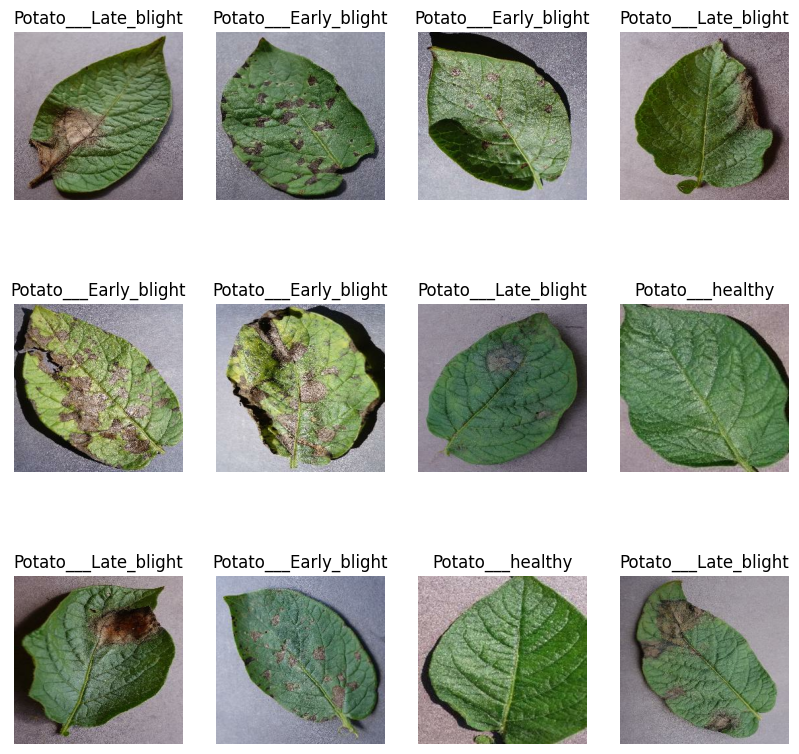

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
# # Define a Function process to Split Dataset into Training(80%), Validation(10%) and Testing(10%) Sets

# # Training: Model learns weights.

# # Validation: Model tuning (hyperparameters, early stopping).

# # Testing: Final unbiased evaluation.

# def train_validation_test_split(dataset, train_size=0.8, validation_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):
#     dataset_batch_count = len(dataset)                                                  # Batch Images dataset Length is 68
#     train_batch_count = int(dataset_batch_count * train_size)                           # int(68*0.8) ---> 54 Batches are Training
#     validation_test_batch_count = int(dataset_batch_count * validation_size)            # int(68*0.1) ---> 6 Batches are validation & Remaining Testing

#     if shuffle:
#         dataset = dataset.shuffle(buffer_size=shuffle_size)                             # Suffling the Dataset help to Model Understand the Data Well

#     train_ds = dataset.take(train_batch_count)                                          # First 74 Batches are Training_Dataset
#     validation_ds = dataset.skip(train_batch_count).take(validation_test_batch_count)   # Next 6 Batch are Validation_Dataset
#     test_ds = dataset.skip(train_batch_count).skip(validation_test_batch_count)         # Pending 8 Batches are Testing

#     return train_ds, validation_ds, test_ds


# # Expected Output

# # Training set = 54 batches (~80%)

# # Validation set = 6 batches (~10%)

# # Test set = 8 batches (~10%)
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
# # Apply the Function in Potato Dataset
# train_ds, validation_ds, test_ds = train_validation_test_split(dataset)
# len(train_ds), len(validation_ds), len(test_ds)

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [ ]:
len(train_ds)


75

In [ ]:
len(val_ds)
len(test_ds)

10

In [ ]:
# Case 1: Shuffle = False
train_ds_no_shuffle, _, _ = train_validation_test_split(dataset, shuffle=False)

print("=== First 2 batches WITHOUT shuffle ===")
for images, labels in train_ds_no_shuffle.take(2):
    print(labels.numpy())   # Print the labels of each batch


=== First 2 batches WITHOUT shuffle ===
[1 1 1 0 1 1 0 1 2 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1]
[1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 2 1 1 0 1 1 1 0 1 1 0 0 0]


In [ ]:
# Case 2: Shuffle = True
train_ds_shuffle, _, _ = train_validation_test_split(dataset, shuffle=True)

print("\n=== First 2 batches WITH shuffle ===")
for images, labels in train_ds_shuffle.take(2):
    print(labels.numpy())   # Print the labels of each batch



=== First 2 batches WITH shuffle ===
[1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 1 0 2 0 0 0 2 2 1 0 1 1 1 0]
[0 2 1 2 0 0 1 1 0 0 1 2 1 1 1 1 0 1 1 2 0 0 1 0 0 0 0 1 0 0 0 1]


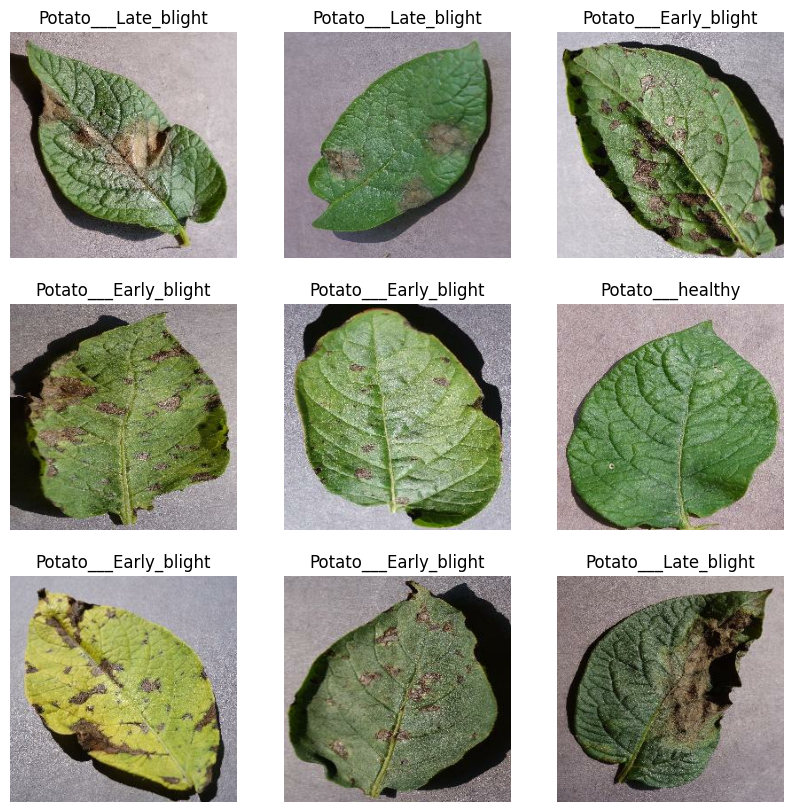

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds_shuffle.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


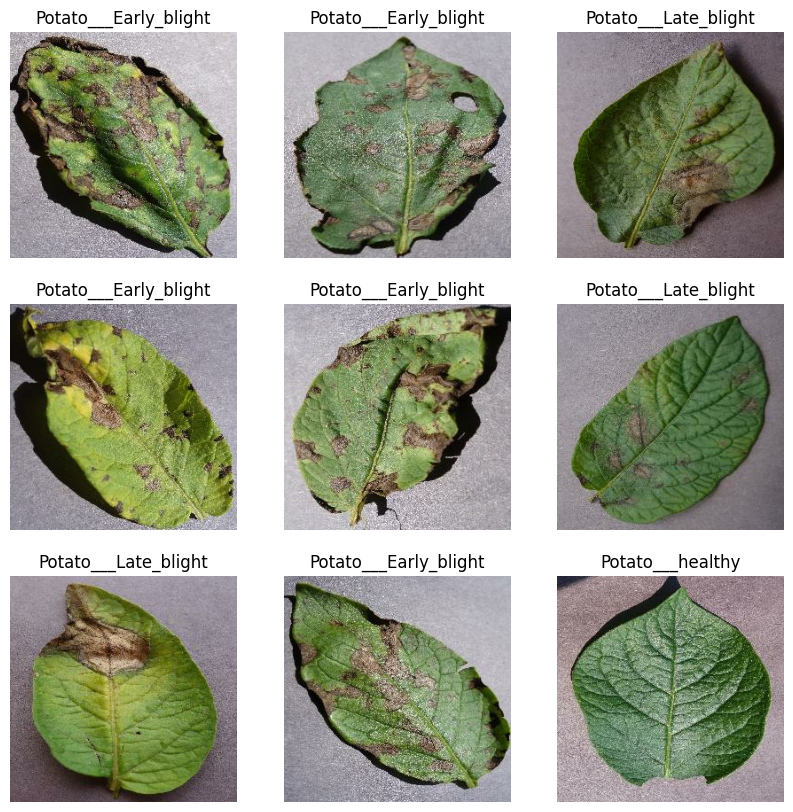

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds_no_shuffle.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


(256, 256, 3)
[[[119. 116. 125.]
  [153. 150. 159.]
  [209. 206. 215.]
  ...
  [173. 171. 182.]
  [170. 168. 179.]
  [169. 167. 178.]]

 [[160. 157. 166.]
  [151. 148. 157.]
  [141. 138. 147.]
  ...
  [174. 172. 183.]
  [173. 171. 182.]
  [173. 171. 182.]]

 [[136. 133. 142.]
  [171. 168. 177.]
  [164. 161. 170.]
  ...
  [174. 172. 183.]
  [176. 174. 185.]
  [177. 175. 186.]]

 ...

 [[169. 165. 179.]
  [154. 150. 164.]
  [131. 127. 141.]
  ...
  [192. 194. 206.]
  [181. 183. 195.]
  [180. 182. 194.]]

 [[191. 187. 201.]
  [153. 149. 163.]
  [145. 141. 155.]
  ...
  [192. 194. 206.]
  [183. 185. 197.]
  [183. 185. 197.]]

 [[197. 193. 207.]
  [150. 146. 160.]
  [152. 148. 162.]
  ...
  [194. 196. 208.]
  [187. 189. 201.]
  [187. 189. 201.]]]

(32,)
0



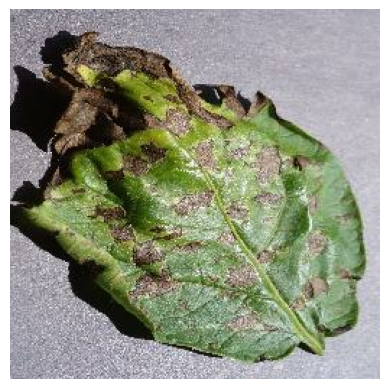

In [ ]:
# Visualize the Image and Label Batches from TensorFlow Dataset

for image_batch, label_batch in train_ds.take(1):
    print(image_batch.numpy()[0].shape)
    print(image_batch.numpy()[0])
    print()

    print(label_batch.numpy().shape)
    print(label_batch.numpy()[0])
    print()

    plt.imshow(image_batch.numpy()[0].astype('uint8'))
    plt.axis('off')

In [ ]:
# Overview of Training Dataset Structure and Specifications
train_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# # Cache, Shuffle, and Prefetch the Dataset
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# validation_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    # Flip images horizontally and vertically
    layers.RandomFlip("horizontal_and_vertical"),

    # Randomly rotate the leaf (±20%)
    layers.RandomRotation(0.2),

    # Randomly zoom in/out (helps model focus on leaf detail or full leaf)
    layers.RandomZoom(0.2),

    #Randomly adjust brightness (simulates different lighting conditions)
    layers.RandomBrightness(factor=0.2),

    # Randomly shift images (leaf positioned differently)
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),

    #  Randomly contrast images (improves robustness to camera differences)
    layers.RandomContrast(factor=0.2),

    #  Optional: Add small amount of Gaussian noise (for better generalization)
    layers.GaussianNoise(0.05)
])


In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Build a Data Augmentation Pipeline
augmentation_pipeline = keras.Sequential([
                                keras.layers.Resizing(height=image_size, width=image_size),
                                # Ensures all images are resized to (256×256) (or whatever image_size is)
                                keras.layers.Rescaling(scale=1./255),
                                # Scale pixels values between 0 and 1.
                                keras.layers.RandomFlip(mode='horizontal_and_vertical'),
                                # Move image in horizontally and vertically
                                keras.layers.RandomRotation(factor=0.2)
                                # Randomly rotate image in upto 20% of 360 degree
                            ])
augmentation_pipeline

<Sequential name=sequential, built=False>

In [ ]:
# train_ds = train_ds.map(
#     lambda x, y: (augmentation_pipeline(x, training=True), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

<Sequential name=sequential_2, built=False>

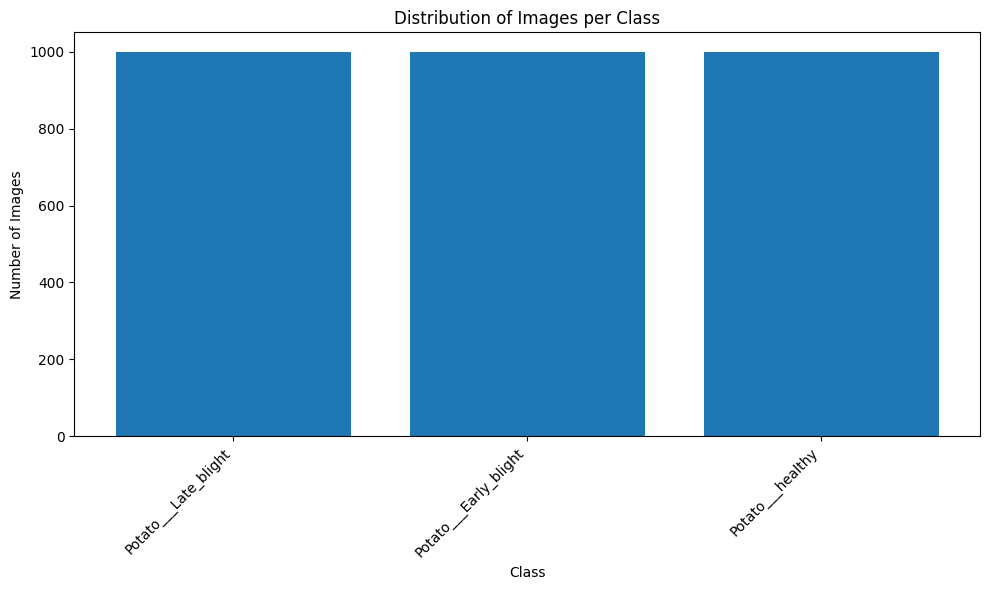

In [ ]:
# Checking Class Distribution.
class_counts = {}
for images, labels in dataset:
    for label in labels.numpy():
        class_name = class_names[label]
        if class_name not in class_counts:
            class_counts[class_name] = 0
        class_counts[class_name] += 1

class_names_list = list(class_counts.keys())
counts_list = list(class_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(class_names_list, counts_list)
plt.title("Distribution of Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Verify the new class distribution in the augmented training dataset
new_class_counts = {}
for images, labels in train_ds:
    # Check if labels is a single tensor or a batch of tensors
    if tf.rank(labels) == 0: # Single label
        label_value = labels.numpy()
        class_name = class_names[label_value]
        if class_name not in new_class_counts:
            new_class_counts[class_name] = 0
        new_class_counts[class_name] += 1
    else: # Batch of labels
        for label in labels.numpy():
            class_name = class_names[label]
            if class_name not in new_class_counts:
                new_class_counts[class_name] = 0
            new_class_counts[class_name] += 1


print("New class distribution in augmented training dataset:")
for class_name, count in new_class_counts.items():
    print(f"{class_name}: {count}")

New class distribution in augmented training dataset:
Potato___healthy: 803
Potato___Late_blight: 789
Potato___Early_blight: 800


In [ ]:
# Define the Parameters of Input_shape, Channel and Target
channel = 3  # RGB ---> Color Images
target  = 3  # len(class_names) ---> ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
input_shape = (32,image_size, image_size, channel)
# input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# n_classes = 3
input_shape


(32, 256, 256, 3)

In [ ]:
# # # Build a CNN Model Architecture

# # model = keras.Sequential([

# #             # Preprocessing Layer
# #             augmentation_pipeline,

# #             # 1st Conv Layer
# #             keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
# #             keras.layers.MaxPooling2D(pool_size=(2, 2)),

# #             # 2nd Conv Layer
# #             keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
# #             keras.layers.MaxPooling2D(pool_size=(2, 2)),

# #             # 3rd Conv Layer
# #             keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
# #             keras.layers.MaxPooling2D(pool_size=(2, 2)),

# #             # 4th Conv Layer
# #             keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
# #             keras.layers.MaxPooling2D(pool_size=(2, 2)),

# #             # 5th Conv Layer
# #             keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
# #             keras.layers.MaxPooling2D(pool_size=(2, 2)),

# #             # 6th Conv Layer
# #             keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
# #             keras.layers.MaxPooling2D(pool_size=(2, 2)),

# #             # Flatten to 1-Dimentional Vector
# #             keras.layers.Flatten(),

# #             # Fully Connected Dense Layer
# #             keras.layers.Dense(units=64, activation='relu'),

# #             # Output Layer
# #             keras.layers.Dense(units=target, activation='softmax')
# #         ])
# # model

# # from tensorflow import keras
# # from tensorflow.keras import layers

# model = keras.Sequential([

#     # Data Augmentation
#     augmentation_pipeline,

#     # 1st Conv Block
#     layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(2, 2),

#     # 2nd Conv Block
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(2, 2),

#     # 3rd Conv Block
#     layers.Conv2D(128, (3,3), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(2, 2),

#     # 4th Conv Block (optional)
#     layers.Conv2D(128, (3,3), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(2, 2),

#     # Replace Flatten with GAP
#     layers.GlobalAveragePooling2D(),

#     # Dense Layers
#     layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
#     layers.Dropout(0.4),

#     # Output Layer (3 classes)
#     layers.Dense(target, activation='softmax')
# ])

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
# model.build(input_shape=input_shape)
# model.summary()
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)


In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=early_stop,
    verbose=1,
    epochs=30,
)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.4096 - loss: 1.0372 - val_accuracy: 0.6181 - val_loss: 0.8347
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.6952 - loss: 0.6719 - val_accuracy: 0.7014 - val_loss: 0.7401
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.7799 - loss: 0.5219 - val_accuracy: 0.7986 - val_loss: 0.4807
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.8177 - loss: 0.3927 - val_accuracy: 0.8125 - val_loss: 0.4335
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.8802 - loss: 0.2998 - val_accuracy: 0.9306 - val_loss: 0.1715
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9273 - loss: 0.1819 - val_accuracy: 0.9444 - val_loss: 0.1321
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.9440 - loss: 0.1582 - val_accuracy: 0.9653 - val_loss: 0.1158
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9471 - loss: 0.1382 - val_accuracy: 0.9444 - v

In [ ]:
# # Compiling the Model with Optimizer, Loss, and Metrics
# early_stop = keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     min_delta=0,
#     patience=20,
#     verbose=0,
#     mode="auto",
#     baseline=None,
#     restore_best_weights=True,
#     start_from_epoch=0,
# )

# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=5e-4), # A less drastic change
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

In [ ]:
# history = model.fit(train_ds,
#                     batch_size=batch_size,
#                     epochs=10,
#                     verbose=1,
#                     validation_data = validation_ds,callbacks=early_stop)
# history

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 260ms/step - accuracy: 0.9975 - loss: 0.0151 - val_accuracy: 0.9757 - val_loss: 0.0694
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 262ms/step - accuracy: 0.9958 - loss: 0.0201 - val_accuracy: 0.9444 - val_loss: 0.2557
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 262ms/step - accuracy: 0.9900 - loss: 0.0305 - val_accuracy: 0.8785 - val_loss: 0.6361
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 261ms/step - accuracy: 0.9970 - loss: 0.0154 - val_accuracy: 0.8854 - val_loss: 0.3654
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 261ms/step - accuracy: 0.9970 - loss: 0.0232 - val_accuracy: 1.0000 - val_loss: 0.0125
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 265ms/step - accuracy: 0.9967 - loss: 0.0200 - val_accuracy: 0.9618 - val_loss: 0.1064
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 250ms/step - accuracy: 0.9978 - loss: 0.0142 - val_accuracy: 0.9340 - val_loss: 0.2249
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 259ms/step - accuracy: 0.9968 - loss: 0.0177 - val_accu

In [ ]:
model.evaluate(test_ds)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9874 - loss: 0.0288


[0.02290191687643528, 0.9906250238418579]

In [ ]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 75}

In [ ]:
# Extracting Accuracy Metrics from Training History
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extracting Loss Metrics from Training History
loss = history.history['loss']
val_loss = history.history['val_loss']


In [ ]:
acc

[0.5081018805503845,
 0.7621527910232544,
 0.8362268805503845,
 0.8657407164573669,
 0.8825231194496155,
 0.9039351940155029,
 0.9375,
 0.9224537014961243,
 0.9473379850387573,
 0.9456018805503845,
 0.9681712985038757,
 0.9728009104728699,
 0.9728009104728699,
 0.9733796119689941,
 0.9675925970077515,
 0.9710648059844971,
 0.9722222089767456,
 0.9780092835426331,
 0.9762731194496155,
 0.9728009104728699,
 0.9728009104728699,
 0.9809027910232544]

Text(0.5, 1.0, 'Training vs Validation Loss')

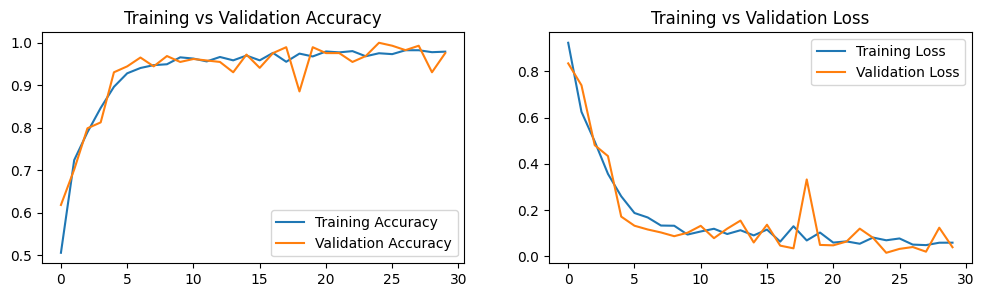

In [ ]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')


In [ ]:
# Accuracy Score

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Confusion matrix of model
# Build Confusion Matrix Graph Also


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9939 - loss: 0.0192
Test Loss: 0.02290191315114498
Test Accuracy: 0.9906250238418579


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get predictions
y_pred_probs = model.predict(test_ds)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels from test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step


In [ ]:
cm = confusion_matrix(y_true, y_pred)
print(cm)


[[42 43 24]
 [47 35 40]
 [22 41 26]]


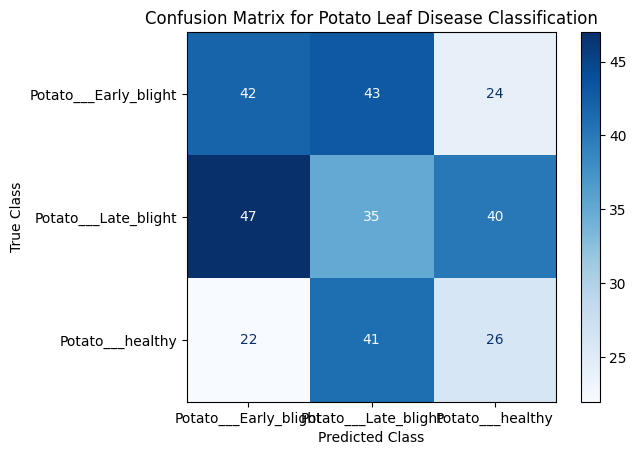

In [ ]:
# Get class names
# class_names = test_ds.class_names # This line caused the error

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')

plt.title("Confusion Matrix for Potato Leaf Disease Classification")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [ ]:
# model.save('/content/drive/MyDrive/DL_SAVED_MODEL/model.h5')
model.save('/content/drive/MyDrive/DL_SAVED_MODEL/bestCNNModel2.h5')

In [ ]:
# Install gradio
# !pip install gradio

import gradio as gr
import tensorflow as tf
import numpy as np
import cv2

# Load your trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/DL_SAVED_MODEL/model.h5')

# Define your class names (same as dataset.class_names)
class_names = ["Early Blight", "Late Blight", "Healthy"]

# Prediction function (matches your manual code)
def predict(img):
    # Convert PIL to numpy
    img = np.array(img)

    # Resize and keep preprocessing same as manual function
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # mimic cv2.imread behavior
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # back to RGB
    img = cv2.resize(img, (256, 256))

    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction)

    return {
        class_names[i]: float(prediction[0][i])
        for i in range(len(class_names))
    }

# Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="Potato Leaf Disease Classifier",
    description="Upload a potato leaf image to detect if it's Healthy, Early Blight, or Late Blight."
)

# Launch with share link (to avoid black screen in Colab)
interface.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e9e3abb76021ec3fce.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e9e3abb76021ec3fce.gradio.live


## Potato Leaf Disease Classification

Developed a Convolutional Neural Network (CNN) model using TensorFlow/Keras for the early detection and classification of potato leaf diseases (Early Blight, Late Blight, Healthy).

*   **Data Preparation:** Utilized a Kaggle dataset, implementing custom data splitting (80% train, 10% validation, 10% test) and advanced data augmentation techniques (flipping, rotation, zoom, brightness, translation, contrast, Gaussian noise) to enhance model robustness and prevent overfitting.
*   **Model Architecture:** Designed and implemented a sequential CNN model incorporating multiple Conv2D, MaxPooling2D, Flatten, and Dense layers, optimized for image feature extraction and classification.
*   **Training & Evaluation:** Trained the model with an Adam optimizer and SparseCategoricalCrossentropy loss, employing EarlyStopping with a patience of 10 epochs. Achieved a **test accuracy of 99.06%** and a test loss of 0.023.
*   **Deployment:** Created an interactive web interface using Gradio for real-time disease prediction from uploaded leaf images, demonstrating practical application of the model.

# Potato Leaf Disease Classification

## Project Overview
This project focuses on building a Convolutional Neural Network (CNN) model to accurately classify potato leaf diseases into three categories: 'Early Blight', 'Late Blight', and 'Healthy'. The goal is to provide a robust solution for early detection of these diseases, which can significantly aid in agricultural management and prevent crop loss.

## Dataset
The dataset used for this project was obtained from Kaggle ([emmarex/plantdisease](https://www.kaggle.com/datasets/emmarex/plantdisease)). It consists of images of potato leaves, categorized into:
*   `Potato___Early_blight`
*   `Potato___Late_blight`
*   `Potato___healthy`

The dataset was downloaded, unzipped, and preprocessed to prepare it for model training.

## Preprocessing and Data Augmentation

### Data Splitting
The dataset was split into training, validation, and testing sets with the following proportions:
*   **Training Set:** 80%
*   **Validation Set:** 10%
*   **Test Set:** 10%

### Image Preprocessing
All images were resized to 256x256 pixels and rescaled to a range of [0, 1] to standardize the input for the neural network.

### Data Augmentation
To improve the model's generalization capabilities and reduce overfitting, various data augmentation techniques were applied to the training dataset, including:
*   Random horizontal and vertical flipping
*   Random rotations
*   Random zooming
*   Random brightness adjustments
*   Random translations
*   Random contrast adjustments
*   Gaussian noise addition

## Model Architecture
The CNN model is a sequential model built using TensorFlow/Keras. It comprises multiple convolutional layers followed by max-pooling layers to extract hierarchical features from the images. The architecture includes:
*   An initial `Resizing` and `Rescaling` layer (as part of the model for inference).
*   Multiple `Conv2D` layers (with 32 or 64 filters, 3x3 kernel, 'relu' activation) for feature extraction.
*   `MaxPooling2D` layers (2x2) for dimensionality reduction.
*   A `Flatten` layer to convert the 2D feature maps into a 1D vector.
*   A `Dense` hidden layer (with 64 units and 'relu' activation).
*   An output `Dense` layer (with 3 units and 'softmax' activation) for multi-class classification.

## Training
The model was compiled with:
*   **Optimizer:** `Adam`
*   **Loss Function:** `SparseCategoricalCrossentropy`
*   **Metrics:** `accuracy`

An `EarlyStopping` callback was used to monitor the `val_loss` with a patience of 10 epochs, ensuring the model stops training when performance on the validation set no longer improves, and restoring the best weights.

The training process ran for a maximum of 30 epochs, with a `BATCH_SIZE` of 32.

## Results
After training, the model achieved impressive performance:
*   **Test Loss:** Approximately 0.023
*   **Test Accuracy:** Approximately 99.06%

A confusion matrix was generated to visualize the classification performance across the three classes.

## Deployment (Gradio Interface)
A simple web interface was built using Gradio to allow for easy testing and prediction. Users can upload an image of a potato leaf, and the interface will display the predicted class and confidence scores for each disease type.